In [1]:
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh import extract_features
from tsfresh.feature_extraction.feature_calculators import set_property
import pycatch22

from autogluon.tabular import TabularPredictor
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")
sns.set_context("talk")
plt.rcParams['font.family'] = 'Arial'

## 0. some functions

### 0.1 tsfresh featurization 

In [2]:
@set_property("fctype", "combiner")
def catch22(x, param):
    """
    pycatch22, a Python library that wraps the CATCH time series characteristics

    Lubba et al. catch22: CAnonical Time-series CHaracteristics, Data Min Knowl Disc 33, 1821 (2019).

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: list of tuples (s, f) where s are the feature name in catch22, serialized as a string,
             and f the respective feature value as bool, int or float
    :return type: pandas.Series
    """
    data = pycatch22.catch22_all(x)

    return [(name, value) for name, value in zip(data['names'], data['values'])]

settings = ComprehensiveFCParameters()
settings[catch22] = None


def conc_points2raw_data(conc_points:dict, sp_mode='sp')->pd.DataFrame:
    data_column = ['id']
    if 's' in sp_mode:
        for i in range(30):
            data_column += [f's{i}']
    if 'p' in sp_mode:
        for i in range(30):
            data_column += [f'p{i}']
    data = pd.DataFrame(columns=data_column)
    cnt = 0
    for idx in conc_points:
        data.loc[cnt, 'id'] = idx
        for i in range(30):
            if 's' in conc_points[idx]:
                data.loc[cnt, f's{i}'] = conc_points[idx]['s'][i]
            if 'p' in conc_points[idx]:
                data.loc[cnt, f'p{i}'] = conc_points[idx]['p'][i]
        cnt += 1
    return data


def preprocess_data_for_tsfresh(data:pd.DataFrame, sp_mode='sp')->pd.DataFrame:
    
    if sp_mode == 'sp':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ss = []
        data_tsfresh_ps = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ss.append(data.loc[i, f's{j}'])
                data_tsfresh_ps.append(data.loc[i, f'p{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['s'] = data_tsfresh_ss
        data_tsfresh['p'] = data_tsfresh_ps

        return data_tsfresh
    
    elif sp_mode == 's':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 's'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ss = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['s'] = data_tsfresh_ss

        return data_tsfresh
    
    elif sp_mode == 'p':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 'p'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ps = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ps.append(data.loc[i, f'p{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['p'] = data_tsfresh_ps

        return data_tsfresh
    
    else:
        raise ValueError('sp_mode can only be sp, s, or p')


def get_tsfresh_features(conc_points:dict, sp_mode='sp')->pd.DataFrame:
    
    data = conc_points2raw_data(conc_points, sp_mode=sp_mode)
    data_tsfresh = preprocess_data_for_tsfresh(data, sp_mode=sp_mode)
    data_tsfresh = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_tsfresh['id'] = data_tsfresh.index
    data_tsfresh = data_tsfresh.reset_index(drop=True)
    # move id to the S3 column
    cols = list(data_tsfresh)
    cols.insert(0, cols.pop(cols.index('id')))
    data_tsfresh = data_tsfresh.loc[:, cols]
    return data_tsfresh

### 0.2 data preprocess

In [3]:
def time_conc_curve_fit(time, conc, max_degree=3, verbose=False):

    for degree in range(1, max_degree+1):
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        time_poly = poly_features.fit_transform(time.reshape(-1, 1))

        # polynomial regression
        model = LinearRegression()
        model.fit(time_poly, conc)

        # predict
        time_plot = time.reshape(-1, 1)
        time_plot_poly = poly_features.transform(time_plot)
        conc_plot = model.predict(time_plot_poly)

        mse = mean_squared_error(conc, conc_plot)
        if degree == 1:
            best_mse = mse
            best_degree = degree
            best_model = model
        else:
            if mse < best_mse:
                best_mse = mse
                best_degree = degree
                best_model = model
    if verbose:
        print('best degree:', best_degree)
        print('best mse:', best_mse)

    return best_model, best_degree


def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


def judege_cat_eq(cat_eq):
    higher_cat_eq = 0.1
    norm_cat_eq = 0.01
    lower_cat_eq = 0.001
    if np.log10(cat_eq) >= np.log10(higher_cat_eq):
        return 'higher_cat'
    elif np.log10(cat_eq) >= np.log10(norm_cat_eq):
        if abs(np.log10(cat_eq) - np.log10(norm_cat_eq)) > abs(np.log10(cat_eq) - np.log10(higher_cat_eq)):
            return 'higher_cat'
        else:
            return 'norm_cat'
    elif np.log10(cat_eq) >= np.log10(lower_cat_eq):
        if abs(np.log10(cat_eq) - np.log10(lower_cat_eq)) > abs(np.log10(cat_eq) - np.log10(norm_cat_eq)):
            return 'norm_cat'
        else:
            return 'lower_cat'
    else:
        return 'lower_cat'
    

def is_quick_rxn(time, conc, obj='s', time_threshold=2/3, conc_threshold=0.05):
    '''
    If the reaction is completed (concentration of substrate less than 0.05) within 2/3 of the total time, return True
    '''
    if obj == 's':
        for t, c in zip(time, conc):
            if t < time_threshold:
                if c < conc_threshold: return True
            else: return False

    elif obj == 'p':
        conc_threshold = 1 - conc_threshold
        for t, c in zip(time, conc):
            if t < time_threshold:
                if c > conc_threshold: return True
            else: return False


def cut_rxn_time(time, conc, obj='s', time_threshold=2/3, conc_threshold=0.05):
    '''
    Cut the reaction time and concentration data one by one from the last point until the reaction is not quick
    '''
    while is_quick_rxn(time, conc, obj=obj, time_threshold=time_threshold, conc_threshold=conc_threshold):
        time = normalize(time[:-1])
        conc = conc[:-1]
    return time, conc


def is_completed_rxn(conc, obj='s', conc_threshold=0.5):
    '''
    If the final substrate concentration is less than 0.5, return True
    '''
    if obj == 's':
        for c in conc:
            if c < conc_threshold: return True
        return False

    elif obj == 'p':
        print('NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn')
        conc_threshold = 1 - conc_threshold
        for c in conc:
            if c > conc_threshold: return True
        return False


def generate_time_conc_curve(
    time, 
    conc,
    max_degree=6,
    plot_fit_str: str | None = None, 
    verbose = False,
    fit=True,
):
    if fit:
        model, degree = time_conc_curve_fit(time, conc, max_degree=max_degree, verbose=verbose)
        time_point = np.linspace(time.min(), time.max(), 30)
        conc_point = model.predict(PolynomialFeatures(degree=degree, include_bias=False).fit_transform(time_point.reshape(-1, 1)))

        if plot_fit_str:
            sns.scatterplot(x=time, y=conc, label=f'{plot_fit_str}')
            sns.lineplot(x=time_point, y=conc_point, label=f'{plot_fit_str}_fit')
            plt.legend(
                loc='upper right',
                bbox_to_anchor=(1.3, 1),
            )
        return time_point, conc_point
    else:
        # reserve 30 point averagely
        time_point = np.linspace(time.min(), time.max(), 30)
        conc_point = np.interp(time_point, time, conc)
        if plot_fit_str:
            sns.scatterplot(x=time, y=conc, label=f'{plot_fit_str}', legend=False)
            sns.lineplot(x=time_point, y=conc_point, label=f'{plot_fit_str}_fit')
        return time_point, conc_point

    
def get_top_x_probs(df, x=3):
    results = {}
    for i in range(1, x+1):
        results[f'list_indices_{i}'] = []
        results[f'list_probs_{i}'] = []
    for _, row in df.iterrows():
        top_x_values = row.nlargest(x).dropna().values
        top_x_indices = row.nlargest(x).index

        for i, (value, index) in enumerate(zip(top_x_values, top_x_indices)):
            results[f'list_indices_{i+1}'].append(index)
            results[f'list_probs_{i+1}'].append(value)
    
    return results

## 1. Prepare experimental data

### 1.1 load experimental data
- `sp_mode`: `s` (only use substrate concentration)

In [4]:
sp_mode = 's'
df_exp = pd.read_csv('./experimental_data/data.csv')
df_exp

,time_1a,S_1a,time_1b,S_1b,time_1d,S_1d,time_1e,S_1e,time_1f,S_1f,time_1g,S_1g,time_1h,S_1h
0,0.0,0.200392,0.0,0.15424,0.0,0.091202,0.0,0.19821,0.0,0.11851,0.0,0.18624,0,0.173485
1,1.0,0.198946,1.0,0.15382,1.0,0.090167,1.0,0.19689,1.0,0.11909,1.0,0.18535,1,0.172805
2,2.0,0.196392,2.0,0.15359,2.0,0.089711,2.0,0.19650,2.0,0.11803,2.0,0.18385,2,0.172297
3,3.0,0.192915,3.0,0.15331,3.0,0.090060,3.0,0.19488,3.0,0.11761,3.0,0.18288,3,0.172854
4,4.0,0.188915,4.0,0.15263,4.0,0.088765,4.0,0.19477,4.0,0.11682,4.0,0.18169,4,0.171546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,618,0.080156
619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619,0.079472
620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,620,0.079252
621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,621,0.078321


### 1.2 read raw data, normalize time and concentration

In [5]:
time_1b = normalize(df_exp['time_1b'].dropna().values)
s_conc_1b = (df_exp['S_1b'].dropna().values - df_exp['S_1b'].dropna().values[-1]) / (df_exp['S_1b'].dropna().values[0] - df_exp['S_1b'].dropna().values[-1])

time_1d = normalize(df_exp['time_1d'].dropna().values)
s_conc_1d = (df_exp['S_1d'].dropna().values - df_exp['S_1d'].dropna().values[-1]) / (df_exp['S_1d'].dropna().values[0] - df_exp['S_1d'].dropna().values[-1])

time_1e = normalize(df_exp['time_1e'].dropna().values)
s_conc_1e = (df_exp['S_1e'].dropna().values - df_exp['S_1e'].dropna().values[-1]) / (df_exp['S_1e'].dropna().values[0] - df_exp['S_1e'].dropna().values[-1])

time_1f = normalize(df_exp['time_1f'].dropna().values)
s_conc_1f = (df_exp['S_1f'].dropna().values - df_exp['S_1f'].dropna().values[-1]) / (df_exp['S_1f'].dropna().values[0] - df_exp['S_1f'].dropna().values[-1])

time_1g = normalize(df_exp['time_1g'].dropna().values)
s_conc_1g = (df_exp['S_1g'].dropna().values - df_exp['S_1g'].dropna().values[-1]) / (df_exp['S_1g'].dropna().values[0] - df_exp['S_1g'].dropna().values[-1])

time_1h = normalize(df_exp['time_1h'].dropna().values)
s_conc_1h = (df_exp['S_1h'].dropna().values - df_exp['S_1h'].dropna().values[-1]) / (df_exp['S_1h'].dropna().values[0] - df_exp['S_1h'].dropna().values[-1])

time_1a = normalize(df_exp['time_1a'].dropna().values)
s_conc_1a = (df_exp['S_1a'].dropna().values - df_exp['S_1a'].dropna().values[-1]) / (df_exp['S_1a'].dropna().values[0] - df_exp['S_1a'].dropna().values[-1])


### 1.3 check data if it is quick rxn or uncompleted rxn

In [6]:
def check_data(time, conc, name, obj='s'):
    '''
    check if the reaction is quick rxn (need to cut), and completed rxn.
    '''
    if is_quick_rxn(time, conc, obj='s'):
        print(f'{name} is quick rxn')
        time, conc = cut_rxn_time(time, conc, obj='s')
        print(f'{name} has been cut')
    else:
        print(f'{name} is fine')

    if is_completed_rxn(conc, obj='s'):
        print(f'{name} is completed rxn')
    else:
        print(f'{name} is not completed rxn')

    return time, conc

time_1b, s_conc_1b = check_data(time_1b, s_conc_1b, '1b')
print('====================')
time_1d, s_conc_1d = check_data(time_1d, s_conc_1d, '1d')
print('====================')
time_1e, s_conc_1e = check_data(time_1e, s_conc_1e, '1e')
print('====================')
time_1f, s_conc_1f = check_data(time_1f, s_conc_1f, '1f')
print('====================')
time_1g, s_conc_1g = check_data(time_1g, s_conc_1g, '1g')
print('====================')
time_1h, s_conc_1h = check_data(time_1h, s_conc_1h, '1h')
print('====================')
time_1a, s_conc_1a = check_data(time_1a, s_conc_1a, '1a')
print('====================')


1b is fine
1b is completed rxn
1d is quick rxn
1d has been cut
1d is completed rxn
1e is fine
1e is completed rxn
1f is fine
1f is completed rxn
1g is fine
1g is completed rxn
1h is fine
1h is completed rxn
1a is fine
1a is completed rxn


### 1.4 fit the time-concentration data with polynomial, to obtain 30 data points with equal intervals.

best degree: 6
best mse: 1.739671049348721e-05
best degree: 6
best mse: 0.00014255534281661499
best degree: 6
best mse: 2.8131581187539527e-05
best degree: 6
best mse: 3.468771967545782e-05
best degree: 6
best mse: 7.918684029026873e-06
best degree: 6
best mse: 7.572331808768317e-05
best degree: 6
best mse: 1.9701417250808083e-05


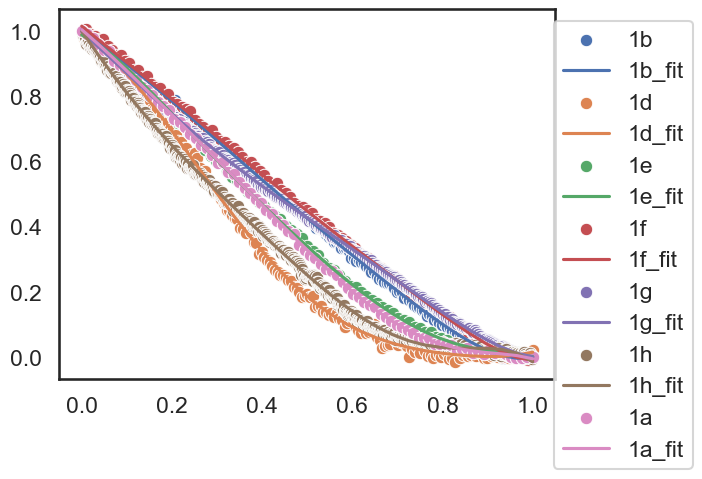

In [7]:
max_degree = 6
fit = True
time_point_1b, s_conc_point_1b = generate_time_conc_curve(time_1b, s_conc_1b, plot_fit_str='1b', verbose=True, fit=fit, max_degree=max_degree)
time_point_1d, s_conc_point_1d = generate_time_conc_curve(time_1d, s_conc_1d, plot_fit_str='1d', verbose=True, fit=fit, max_degree=max_degree)
time_point_1e, s_conc_point_1e = generate_time_conc_curve(time_1e, s_conc_1e, plot_fit_str='1e', verbose=True, fit=fit, max_degree=max_degree)
time_point_1f, s_conc_point_1f = generate_time_conc_curve(time_1f, s_conc_1f, plot_fit_str='1f', verbose=True, fit=fit, max_degree=max_degree)
time_point_1g, s_conc_point_1g = generate_time_conc_curve(time_1g, s_conc_1g, plot_fit_str='1g', verbose=True, fit=fit, max_degree=max_degree)
time_point_1h, s_conc_point_1h = generate_time_conc_curve(time_1h, s_conc_1h, plot_fit_str='1h', verbose=True, fit=fit, max_degree=max_degree)
time_point_1a, s_conc_point_1a = generate_time_conc_curve(time_1a, s_conc_1a, plot_fit_str='1a', verbose=True, fit=fit, max_degree=max_degree)

### 1.5 featurize the data with tsfresh, merged with raw data

In [8]:
df_exp_tsfresh_data = get_tsfresh_features(
    {
        '1b': {'s': s_conc_point_1b},
        '1d': {'s': s_conc_point_1d},
        '1e': {'s': s_conc_point_1e},
        '1f': {'s': s_conc_point_1f},
        '1g': {'s': s_conc_point_1g},
        '1h': {'s': s_conc_point_1h},
        '1a': {'s': s_conc_point_1a},
    },
    sp_mode=sp_mode
)

df_exp_raw_data = conc_points2raw_data(
    {
        '1b': {'s': s_conc_point_1b},
        '1d': {'s': s_conc_point_1d},
        '1e': {'s': s_conc_point_1e},
        '1f': {'s': s_conc_point_1f},
        '1g': {'s': s_conc_point_1g},
        '1h': {'s': s_conc_point_1h},
        '1a': {'s': s_conc_point_1a},
    },
    sp_mode=sp_mode
)

df_exp_merged_data = pd.merge(df_exp_raw_data, df_exp_tsfresh_data, on='id')
df_exp_merged_data

Feature Extraction: 100%|██████████| 7/7 [00:00<00:00, 197.65it/s]


,id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s__catch22__FC_LocalSimple_mean1_tauresrat,s__catch22__DN_OutlierInclude_p_001_mdrmd,s__catch22__DN_OutlierInclude_n_001_mdrmd,s__catch22__SP_Summaries_welch_rect_area_5_1,s__catch22__SB_BinaryStats_diff_longstretch0,s__catch22__SB_MotifThree_quantile_hh,s__catch22__SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,s__catch22__SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,s__catch22__SP_Summaries_welch_rect_centroid,s__catch22__FC_LocalSimple_mean3_stderr
0,1b,1.00502,0.968922,0.932469,0.895212,0.856938,0.817611,0.777325,0.736263,0.694654,...,0.818182,-0.700000,0.700000,0.868486,28.0,1.321604,0.0,0.0,0.19635,0.054837
1,1d,0.99034,0.956373,0.913715,0.863485,0.80701,0.745742,0.681194,0.614878,0.548249,...,0.909091,-0.733333,0.566667,0.870942,26.0,1.321604,0.0,0.0,0.19635,0.145863
2,1e,0.989088,0.961654,0.925032,0.882289,0.835752,0.787128,0.737621,0.688037,0.638875,...,0.818182,-0.700000,0.633333,0.871427,28.0,1.321604,0.0,0.0,0.19635,0.087999
3,1f,1.016177,0.977115,0.938963,0.900986,0.862735,0.823989,0.784697,0.744929,0.704835,...,0.909091,-0.700000,0.733333,0.859135,28.0,1.321604,0.0,0.0,0.19635,0.036199
4,1g,0.998891,0.955581,0.911417,0.867071,0.823079,0.779852,0.737682,0.696757,0.657168,...,1.090909,-0.733333,0.733333,0.849002,28.0,1.321604,0.0,0.0,0.19635,0.042202
5,1h,1.000863,0.932097,0.866553,0.804666,0.746448,0.69161,0.639677,0.590078,0.542236,...,0.909091,-0.733333,0.600000,0.841419,25.0,1.321604,0.0,0.0,0.19635,0.122772
6,1a,1.005133,0.963376,0.919357,0.873979,0.827816,0.781195,0.73427,0.687083,0.639622,...,0.818182,-0.700000,0.633333,0.868675,28.0,1.321604,0.0,0.0,0.19635,0.094145


## 2. Predict on wet-lab data using 4-class model
- `feat`: `tsfresh_raw` (use both tsfresh features and raw data)
- `ag_train_quality`: `best_quality` (use `best_quality` present in Autogluon training)
- `hours`: `3.0` (train for 3.0 hours)

In [9]:
class_4_list = [
    'S1',
    'S2',
    'S3',
    'S4',
    # 'S5',
]
class_num = len(class_4_list)

ag_model_root = './AutogluonModels/'
feat = 'tsfresh_raw'
ag_train_quality = 'best_quality'
hours = 3.0
label_col = 'class'
random_seed = 42

### 2.1 load model

In [10]:
model_4_class_root = os.path.join(ag_model_root, f'{str(class_num)}_class', f'{feat}_feat__{sp_mode}__{ag_train_quality}__{hours}h')
predictor_4_class = TabularPredictor.load(model_4_class_root)

### 2.2 predict and show the result

In [11]:
exp_proba_4_class = predictor_4_class.predict_proba(df_exp_merged_data)

In [12]:
df_exp_pred_results_4_class = pd.DataFrame({
    'id': df_exp_merged_data['id'],
    'pred_1st': get_top_x_probs(exp_proba_4_class, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(exp_proba_4_class, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(exp_proba_4_class, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(exp_proba_4_class, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(exp_proba_4_class, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(exp_proba_4_class, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(exp_proba_4_class, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(exp_proba_4_class, x=4)['list_probs_4'],
})
df_exp_pred_results_4_class = df_exp_pred_results_4_class.round(3)
df_exp_pred_results_4_class

,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba
0,1b,S2,0.661,S1,0.303,S3,0.018,S4,0.018
1,1d,S2,0.904,S3,0.054,S1,0.025,S4,0.017
2,1e,S2,0.884,S1,0.096,S3,0.015,S4,0.005
3,1f,S2,0.734,S1,0.240,S3,0.013,S4,0.013
4,1g,S3,0.704,S2,0.253,S4,0.026,S1,0.017
5,1h,S3,0.845,S4,0.093,S2,0.057,S1,0.005
6,1a,S2,0.814,S1,0.158,S3,0.015,S4,0.013


In [13]:
df_exp_pred_results_4_class_T = df_exp_pred_results_4_class.T
df_exp_pred_results_4_class_T

,0,1,2,3,4,5,6
id,1b,1d,1e,1f,1g,1h,1a
pred_1st,S2,S2,S2,S2,S3,S3,S2
pred_1st_proba,0.661,0.904,0.884,0.734,0.704,0.845,0.814
pred_2nd,S1,S3,S1,S1,S2,S4,S1
pred_2nd_proba,0.303,0.054,0.096,0.24,0.253,0.093,0.158
pred_3rd,S3,S1,S3,S3,S4,S2,S3
pred_3rd_proba,0.018,0.025,0.015,0.013,0.026,0.057,0.015
pred_4th,S4,S4,S4,S4,S1,S1,S4
pred_4th_proba,0.018,0.017,0.005,0.013,0.017,0.005,0.013


### 2.3 draw figures

In [14]:
exp_proba_4_class = exp_proba_4_class[class_4_list]
pie_data_4_class = {
    '1b': exp_proba_4_class.iloc[0].tolist(),
    '1d': exp_proba_4_class.iloc[1].tolist(),
    '1e': exp_proba_4_class.iloc[2].tolist(),
    '1f': exp_proba_4_class.iloc[3].tolist(),
    '1g': exp_proba_4_class.iloc[4].tolist(),
    '1h': exp_proba_4_class.iloc[5].tolist(),
    '1a': exp_proba_4_class.iloc[6].tolist(),
}
pie_colors_4_class = ['#FFA878', '#79A1E3', '#88D59A', '#E37275']

#### 2.3.1 1a (1.0 mol%)

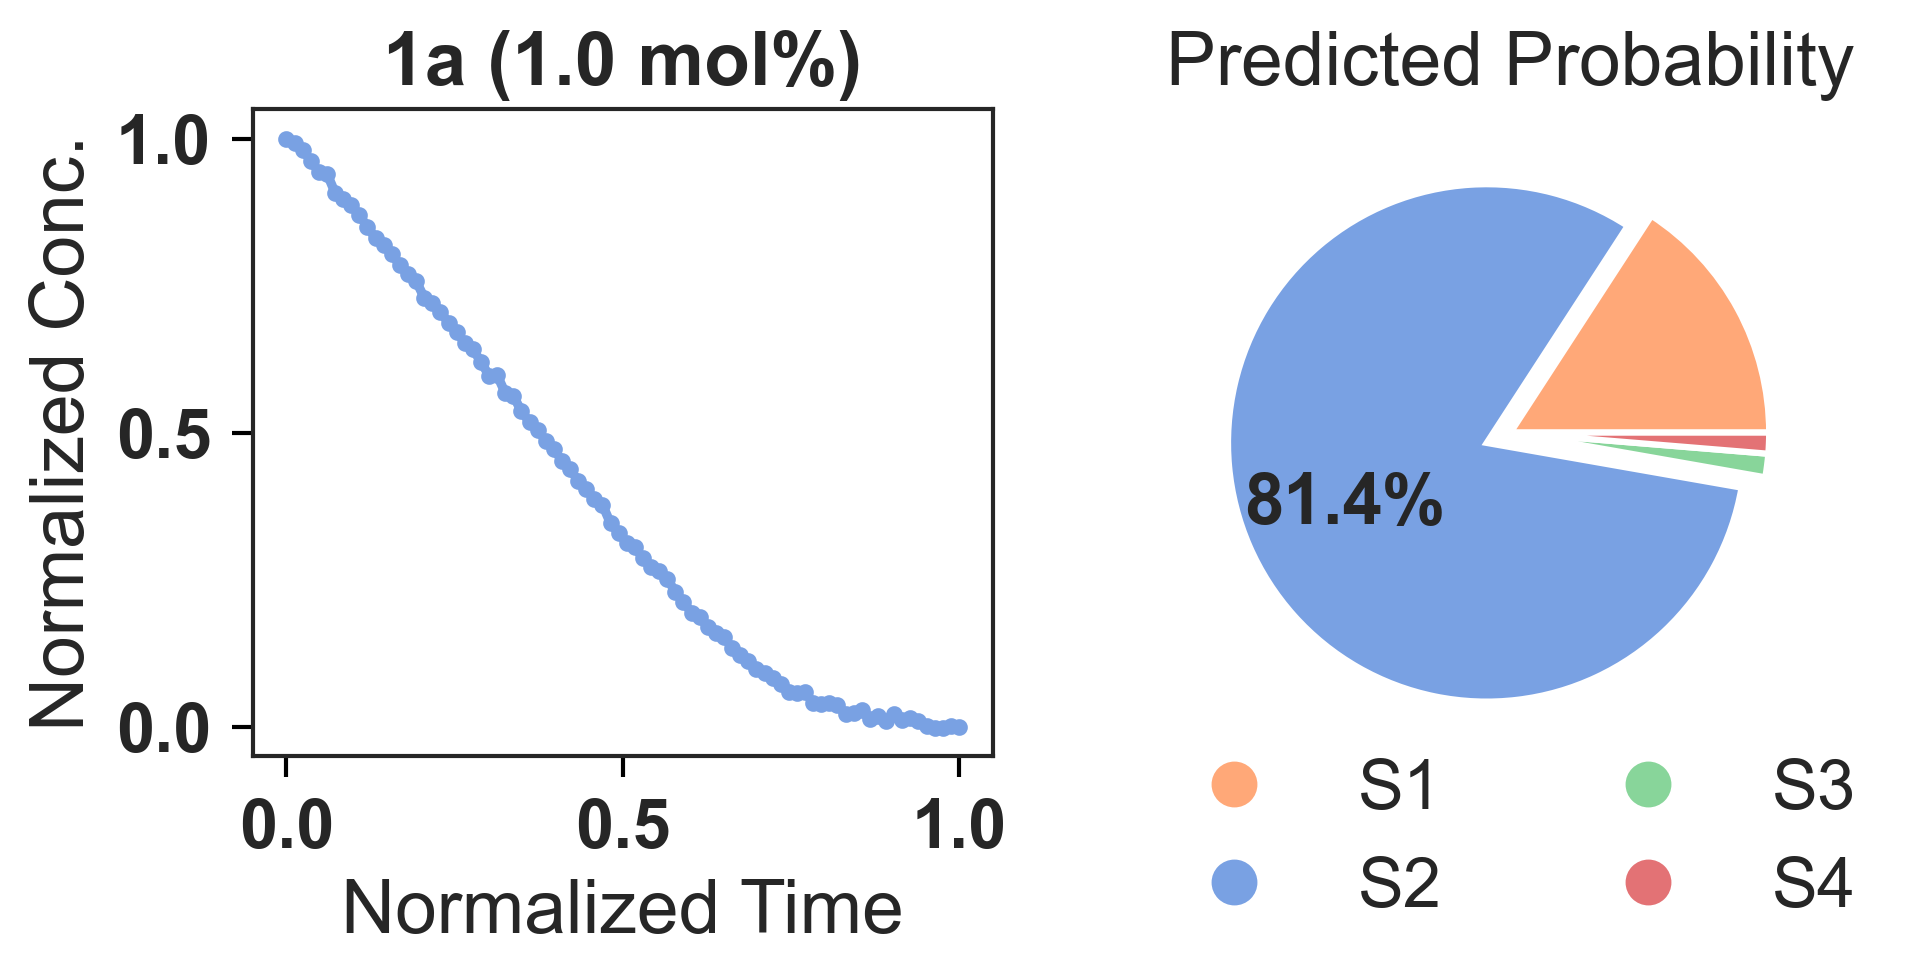

In [15]:
def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''

fig, axes = plt.subplots(1, 2, figsize=(7, 2.8), dpi=300)
axes[0].plot(time_1a, s_conc_1a, 
            #  label='Exp. Data', 
             marker='o', markersize=3,
             color=pie_colors_4_class[pie_data_4_class['1a'].index(max(pie_data_4_class['1a']))]
             )
# axes[0].legend(['Exp. Data'], loc='upper right', frameon=True, fontsize=12)
axes[0].set_title('1a (1.0 mol%)', fontweight='bold')
axes[0].set_xlabel('Normalized Time')
axes[0].set_ylabel('Normalized Conc.')
axes[0].set_ylim(-0.05, 1.05)
axes[0].set_yticks([0, 0.5, 1])
for tick_label in axes[0].get_xticklabels():
    tick_label.set_fontweight('bold')
for tick_label in axes[0].get_yticklabels():
    tick_label.set_fontweight('bold')
for spine in axes[0].spines.values(): 
    spine.set_linewidth(1)
axes[0].tick_params(
    axis='both',          # Apply to x and y axes
    which='major',        # Apply to major ticks
    direction='out',      # Ticks point outwards (in, out, inout)
    length=5,             # Length of the ticks
    width=1,              # Width of the ticks (ensure greater than 0, e.g., 0.5, 0.8, 1)
    color='black',        # Color of the ticks (ensure contrast with background)
    pad=5,                # Distance between ticks and labels
    bottom=True,          # Show bottom x-axis ticks
    left=True,            # Show left y-axis ticks
    top=False,            # Do not show top x-axis ticks (unless needed)
    right=False           # Do not show right y-axis ticks (unless needed)
)

explode = [0.1 if size == max(pie_data_4_class['1a']) else 0 for size in pie_data_4_class['1a']]

axes[1].pie(
    pie_data_4_class['1a'],
    autopct=lambda pct: autopct_only_max(pct, pie_data_4_class['1a']),
    startangle=0,
    colors=pie_colors_4_class,
    explode=explode,
    textprops={'fontweight': 'bold', 'fontsize': 17} 
)
axes[1].set_title('Predicted Probability')
axes[1].legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_4_class],
    labels=['S1', 'S2', 'S3', 'S4'],
    # labels=class_4_list,
    loc='lower center',           
    bbox_to_anchor=(0.5, -0.35), 
    ncol=2,
    frameon=False
    )

plt.show()

#### 2.3.2 1b-1h

/tmp/ipykernel_2917276/1671232876.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


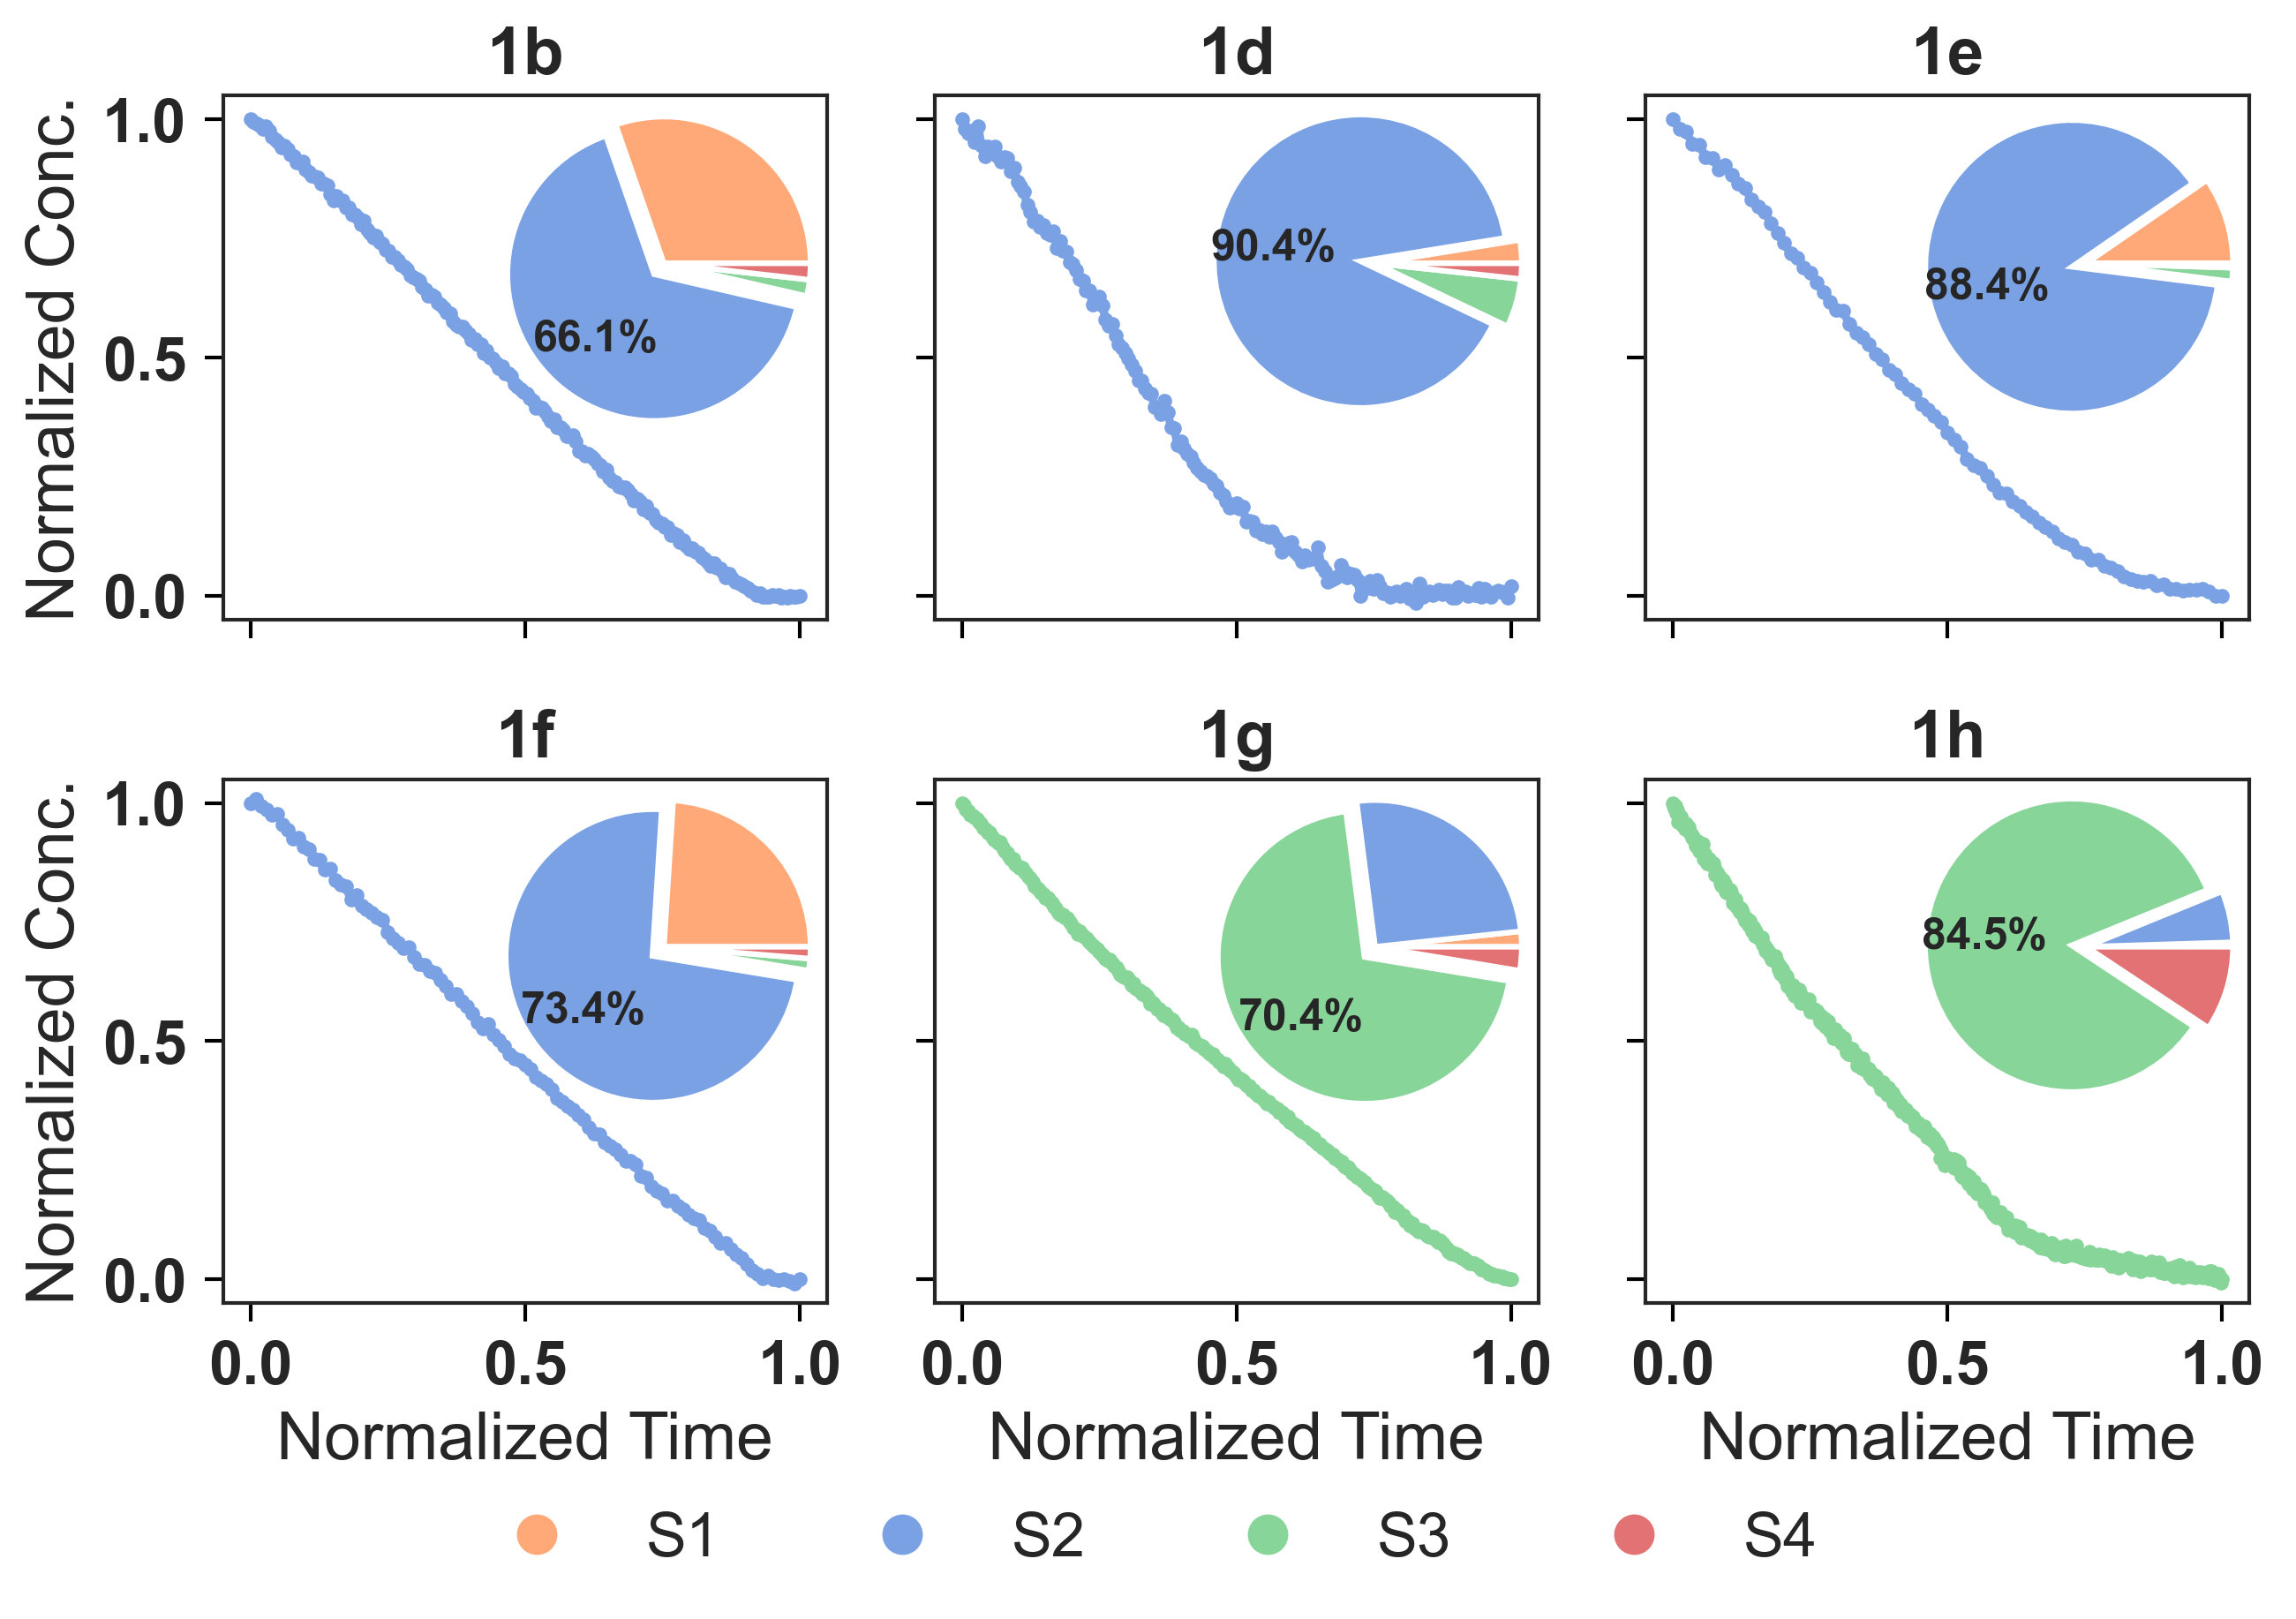

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''
    

fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=300)
axes = axes.flatten()

s_conc_data = [s_conc_1b, s_conc_1d, s_conc_1e, s_conc_1f, s_conc_1g, s_conc_1h]
time_data = [time_1b, time_1d, time_1e, time_1f, time_1g, time_1h]
titles = ['1b', '1d', '1e', '1f', '1g', '1h']

for i, ax in enumerate(axes):
    ax.plot(time_data[i], s_conc_data[i], 
            # label='Exp. Data', 
            marker='o', markersize=3,
            color=pie_colors_4_class[pie_data_4_class[titles[i]].index(max(pie_data_4_class[titles[i]]))]
            )
    ax.set_title(titles[i], fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
# Apply a uniform tick style to all ticks
    ax.tick_params(
        axis='both',
        which='major',
        direction='out',
        length=5,
        width=1,
        color='black',
        pad=5,
        bottom=True,  # Ensure ticks are drawn on the required sides
        left=True,    # Ensure ticks are drawn on the required sides
        top=False,    # Usually, ticks on the top and right are not displayed
        right=False
    )

    # Set Y-axis based on conditions
    if i % 3 == 0: # Need to display Y-axis label and specific Y tick values
        ax.set_ylabel('Normalized Conc.')
        ax.set_yticks([0, 0.5, 1])
        # Tick value labels will be generated automatically and will be bolded later
    else: # Only need to display Y ticks, not the Y-axis label and Y tick values
        ax.set_ylabel('')
        # Matplotlib will automatically generate Y tick positions based on data (if ylim is set, it will be based on ylim)
        # If ax.set_yticks() is not called, automatic ticks will be used
        # If you want to force specific tick positions without labels:
        # ax.set_yticks([desired_tick_positions_without_labels])
        ax.set_yticklabels([]) # Hide Y tick values

    # Set X-axis based on conditions
    if i >= 3: # Need to display X-axis label and specific X tick values (assuming i is a zero-based index)
        ax.set_xlabel('Normalized Time')
        ax.set_xticks([0, 0.5, 1])
        # Tick value labels will be generated automatically and will be bolded later
    else: # Only need to display X ticks, not the X-axis label and X tick values
        ax.set_xlabel('')
        # Matplotlib will automatically generate X tick positions based on data
        # If ax.set_xticks() is not called, automatic ticks will be used
        # If you want to force specific tick positions without labels:
        # ax.set_xticks([desired_tick_positions_without_labels])
        ax.set_xticklabels([]) # Hide X tick values

    # Bold all visible tick labels
    # For axes that called set_xticklabels([]) or set_yticklabels([]),
    # get_xticklabels() will return Text objects, but their contents are empty strings, so bolding has no visual effect, which is expected.
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('bold')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('bold')

    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(1)

    inset_ax = inset_axes(ax, 
                      width="70%", 
                      height="70%", 
                      loc="center right", 
                      bbox_to_anchor=(0.13, 0.18, 1, 1),
                      bbox_transform=ax.transAxes)
    explode = [0.1 if size == max(pie_data_4_class[titles[i]]) else 0 for size in pie_data_4_class[titles[i]]]
    inset_ax.pie(
        pie_data_4_class[titles[i]],
        autopct=lambda pct: autopct_only_max(pct, pie_data_4_class[titles[i]]),
        startangle=0,
        colors=pie_colors_4_class,
        explode=explode,
        textprops={'fontweight': 'bold', 'fontsize': 12}
    )

fig.legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_4_class],
    labels=class_4_list,
    loc='lower center',          
    bbox_to_anchor=(0.5, -0.05),   
    ncol=6,
    # fontsize=16,
    frameon=False                 
)
plt.tight_layout()
plt.show()


## 3. Predict on wet-lab data using 5-class model
- `feat`: `tsfresh_raw` (use both tsfresh features and raw data)
- `ag_train_quality`: `best_quality` (use `best_quality` present in Autogluon training)
- `hours`: `3.0` (train for 3.0 hours)

In [17]:
class_5_list = [
    'S1',
    'S2',
    'S3',
    'S4',
    'S5',
]
class_num = len(class_5_list)

ag_model_root = './AutogluonModels/'
feat = 'tsfresh_raw'
ag_train_quality = 'best_quality'
hours = 3.0
label_col = 'class'
random_seed = 42

### 3.1 load model

In [18]:
model_5_class_root = os.path.join(ag_model_root, f'{str(class_num)}_class', f'{feat}_feat__{sp_mode}__{ag_train_quality}__{hours}h')
predictor_5_class = TabularPredictor.load(model_5_class_root)

### 3.2 predict and show the result

In [19]:
exp_proba_5_class = predictor_5_class.predict_proba(df_exp_merged_data)

In [20]:
df_exp_pred_results_5_class = pd.DataFrame({
    'id': df_exp_merged_data['id'],
    'pred_1st': get_top_x_probs(exp_proba_5_class, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(exp_proba_5_class, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(exp_proba_5_class, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(exp_proba_5_class, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(exp_proba_5_class, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(exp_proba_5_class, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(exp_proba_5_class, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(exp_proba_5_class, x=4)['list_probs_4'],
    'pred_5th': get_top_x_probs(exp_proba_5_class, x=5)['list_indices_5'],
    'pred_5th_proba': get_top_x_probs(exp_proba_5_class, x=5)['list_probs_5'],
})
df_exp_pred_results_5_class = df_exp_pred_results_5_class.round(3)
df_exp_pred_results_5_class

,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba,pred_5th,pred_5th_proba
0,1b,S2,0.759,S1,0.184,S5,0.019,S3,0.019,S4,0.019
1,1d,S2,0.867,S5,0.075,S3,0.020,S1,0.019,S4,0.018
2,1e,S2,0.931,S5,0.020,S1,0.018,S3,0.016,S4,0.015
3,1f,S2,0.747,S1,0.196,S5,0.019,S3,0.019,S4,0.019
4,1g,S5,0.768,S3,0.134,S2,0.046,S4,0.033,S1,0.020
5,1h,S5,0.573,S3,0.332,S4,0.052,S2,0.022,S1,0.020
6,1a,S2,0.913,S1,0.036,S5,0.017,S3,0.017,S4,0.017


In [ ]:
df_exp_pred_results_5_class_T = df_exp_pred_results_5_class.T
df_exp_pred_results_5_class_T

,0,1,2,3,4,5,6
id,1b,1d,1e,1f,1g,1h,1a
pred_1st,S2,S2,S2,S2,S5,S5,S2
pred_1st_proba,0.759,0.867,0.931,0.747,0.768,0.573,0.913
pred_2nd,S1,S5,S5,S1,S3,S3,S1
pred_2nd_proba,0.184,0.075,0.02,0.196,0.134,0.332,0.036
pred_3rd,S5,S3,S1,S5,S2,S4,S5
pred_3rd_proba,0.019,0.02,0.018,0.019,0.046,0.052,0.017
pred_4th,S3,S1,S3,S3,S4,S2,S3
pred_4th_proba,0.019,0.019,0.016,0.019,0.033,0.022,0.017
pred_5th,S4,S4,S4,S4,S1,S1,S4


### 3.3 draw figures

In [22]:
exp_proba_5_class = exp_proba_5_class[class_5_list]
pie_data_5_class = {
    '1b': exp_proba_5_class.iloc[0].tolist(),
    '1d': exp_proba_5_class.iloc[1].tolist(),
    '1e': exp_proba_5_class.iloc[2].tolist(),
    '1f': exp_proba_5_class.iloc[3].tolist(),
    '1g': exp_proba_5_class.iloc[4].tolist(),
    '1h': exp_proba_5_class.iloc[5].tolist(),
    '1a': exp_proba_5_class.iloc[6].tolist(),
}
pie_colors_5_class = ['#FFA878', '#79A1E3', '#88D59A', '#E37275', '#AB9FD6']

#### 3.3.1 1a (1.0 mol%)

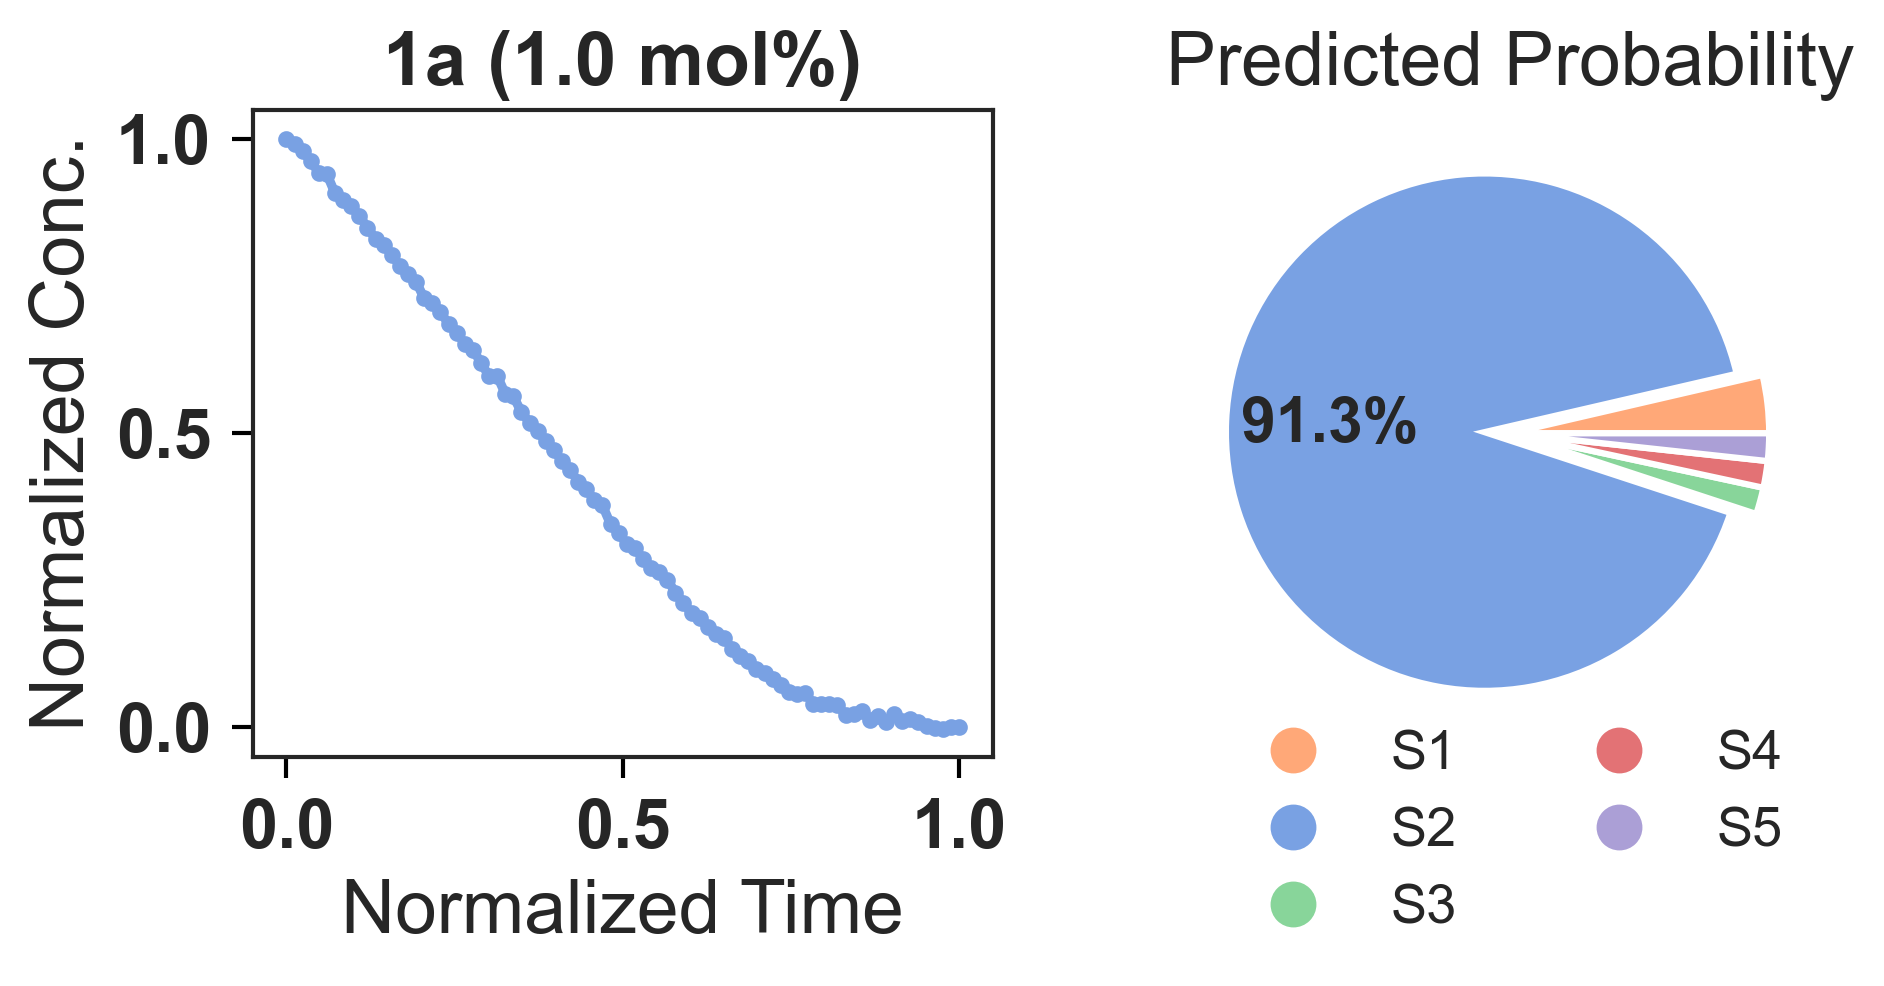

In [ ]:
def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''

fig, axes = plt.subplots(1, 2, figsize=(7, 2.8), dpi=300)
axes[0].plot(time_1a, s_conc_1a, 
             label='Exp. Data', 
             marker='o', markersize=3,
             color=pie_colors_5_class[pie_data_5_class['1a'].index(max(pie_data_5_class['1a']))]
             )
# axes[0].legend(['Exp. Data'], loc='upper right', frameon=True, fontsize=12)
axes[0].set_title('1a (1.0 mol%)', fontweight='bold')
axes[0].set_xlabel('Normalized Time')
axes[0].set_ylabel('Normalized Conc.')
axes[0].set_ylim(-0.05, 1.05)
axes[0].set_yticks([0, 0.5, 1])
for tick_label in axes[0].get_xticklabels():
    tick_label.set_fontweight('bold')
for tick_label in axes[0].get_yticklabels():
    tick_label.set_fontweight('bold')
for spine in axes[0].spines.values(): 
    spine.set_linewidth(1) 
axes[0].tick_params(
    axis='both',          # Apply to both x and y axes
    which='major',        # Apply to major ticks
    direction='out',      # Ticks point outwards (in, out, inout)
    length=5,             # Length of the ticks
    width=1,              # Width of the ticks (ensure greater than 0, e.g., 0.5, 0.8, 1)
    color='black',        # Color of the ticks (ensure contrast with background)
    pad=5,                # Distance between ticks and labels
    bottom=True,          # Show bottom x-axis ticks
    left=True,            # Show left y-axis ticks
    top=False,            # Do not show top x-axis ticks (unless needed)
    right=False           # Do not show right y-axis ticks (unless needed)
)
explode = [0.1 if size == max(pie_data_5_class['1a']) else 0 for size in pie_data_5_class['1a']]

axes[1].pie(
    pie_data_5_class['1a'],
    autopct=lambda pct: autopct_only_max(pct, pie_data_5_class['1a']),
    startangle=0,
    colors=pie_colors_5_class,
    explode=explode,
    textprops={'fontweight': 'bold', 'fontsize': 15},
    radius=1,
    center=(0.5, 0.2)
)
axes[1].set_title('Predicted Probability')

axes[1].legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_5_class],
    labels=class_5_list,
    loc='lower center',           
    bbox_to_anchor=(0.5, -0.35), 
    ncol=2,
    fontsize=13,
    frameon=False
    )

plt.show()

#### 3.3.2 1b-1h

/tmp/ipykernel_2181134/2229675218.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


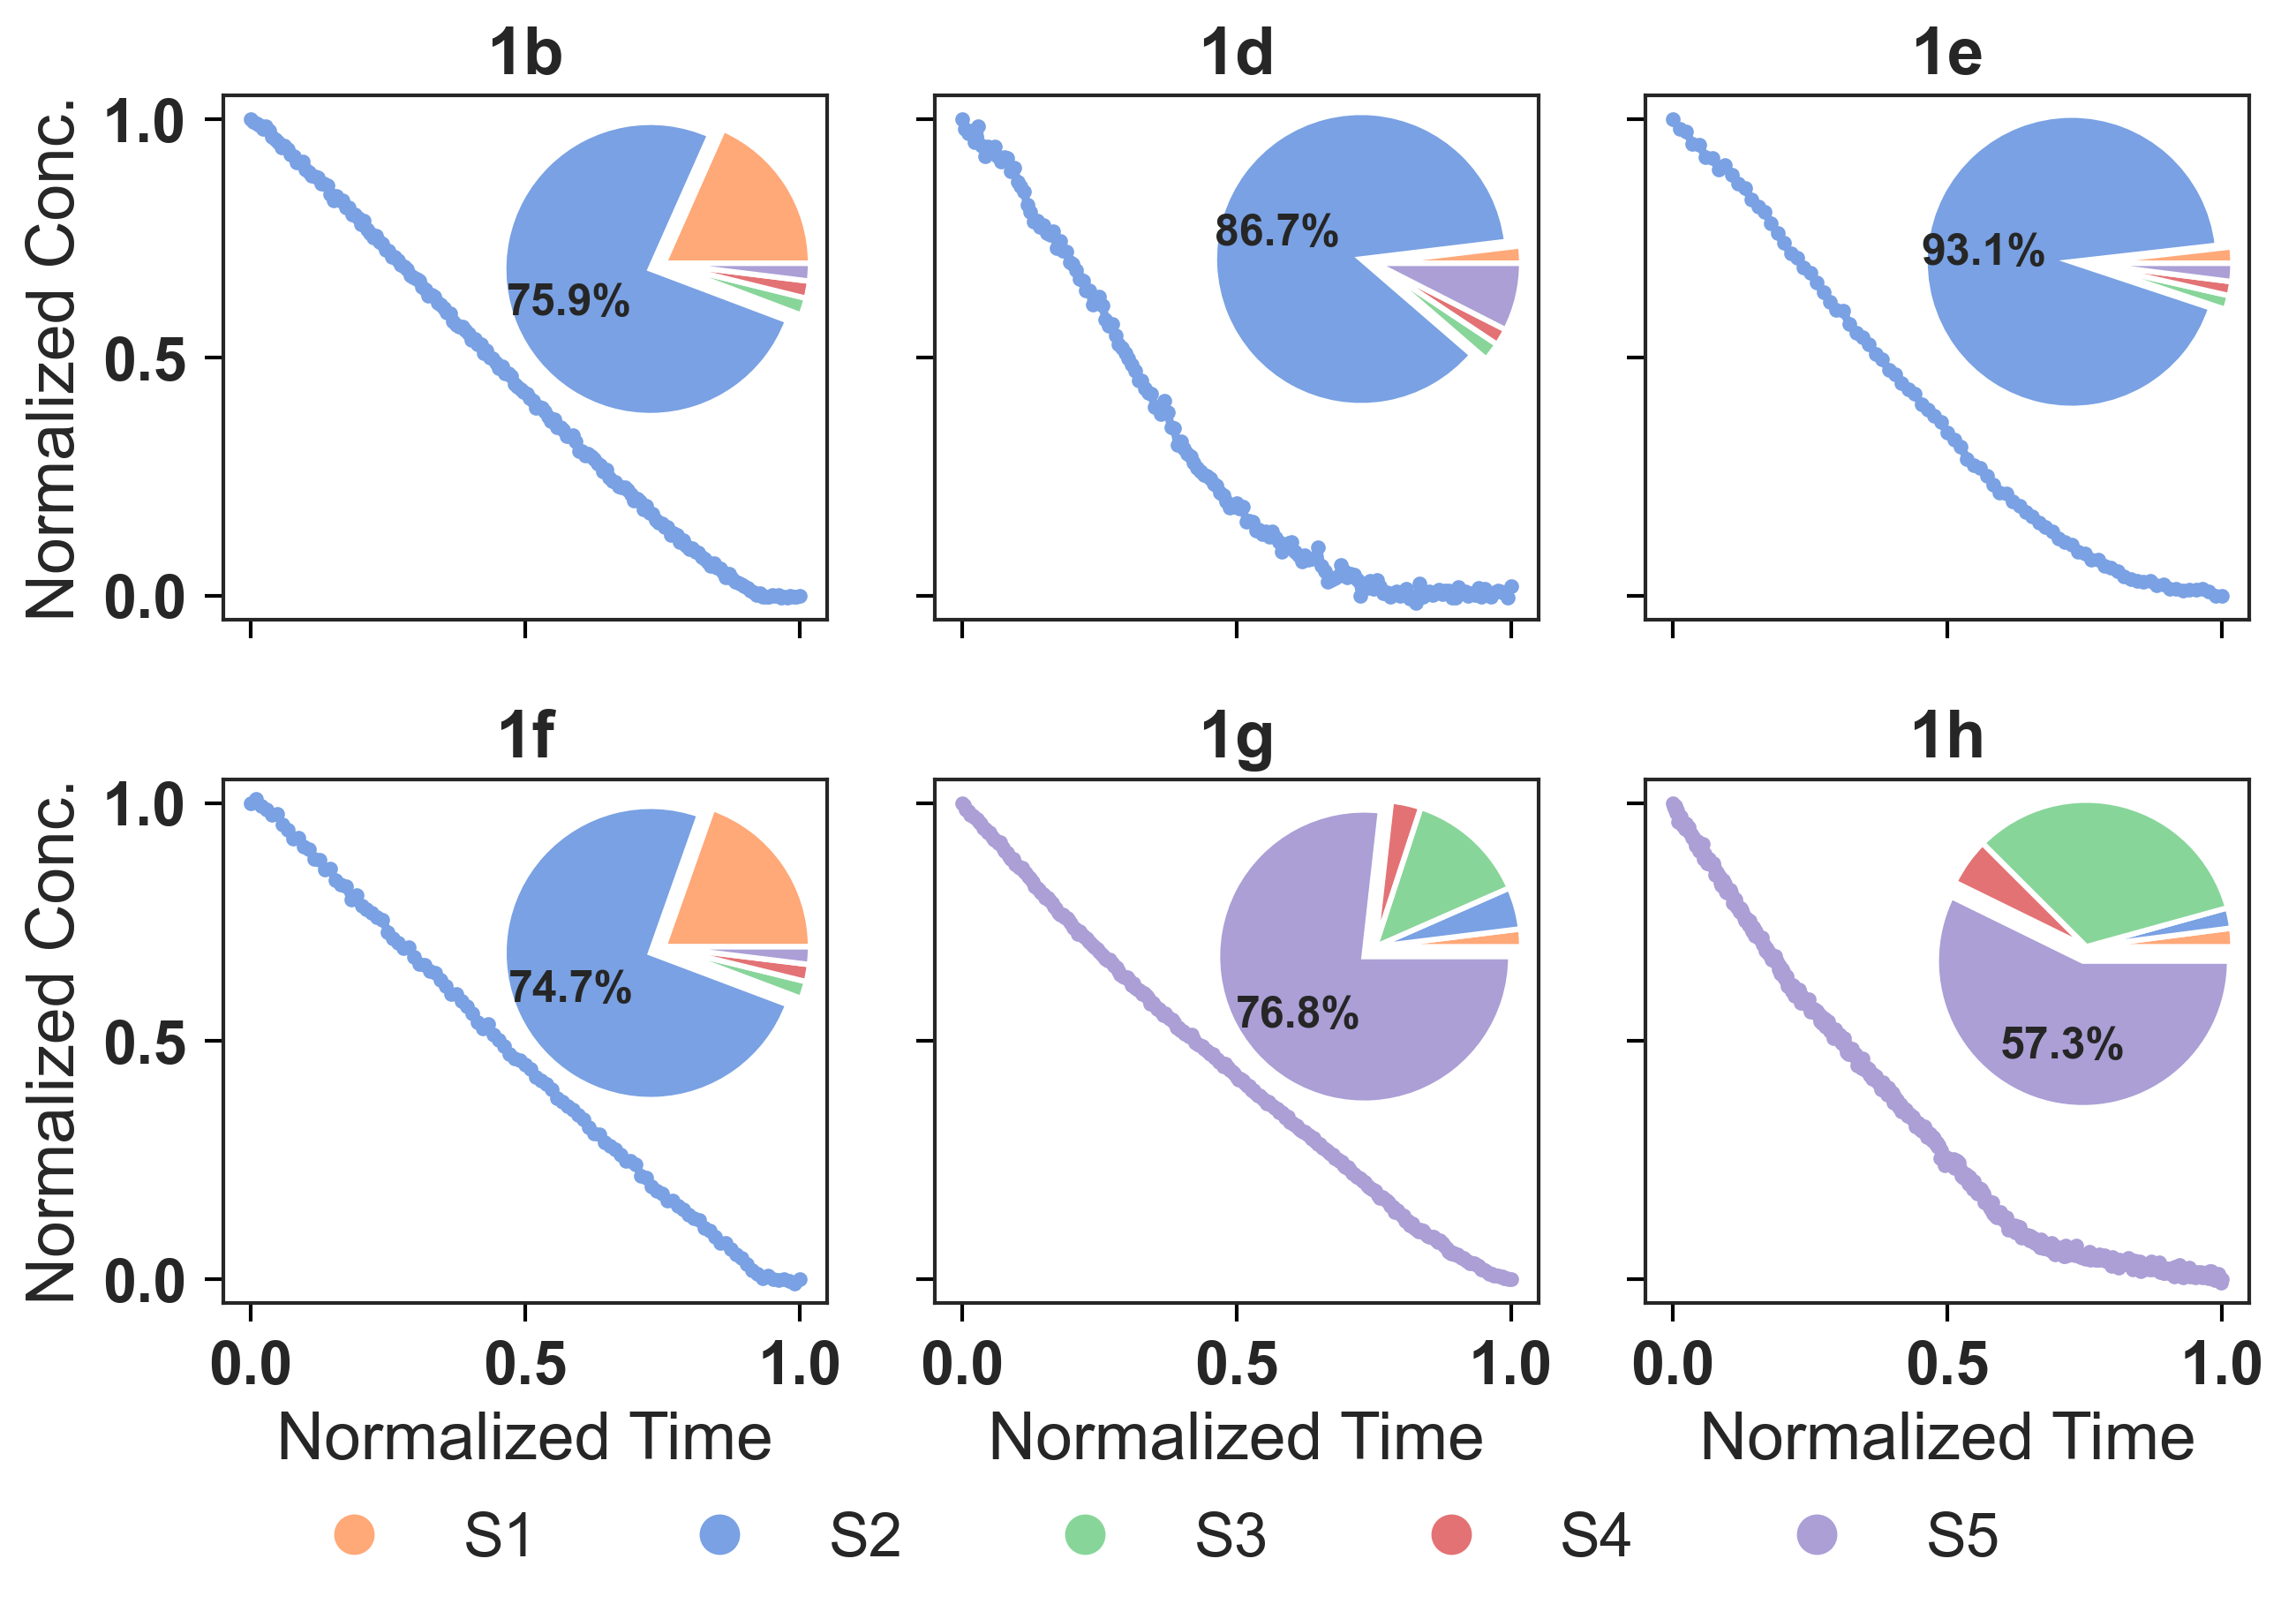

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''
    

fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=300)
axes = axes.flatten()

s_conc_data = [s_conc_1b, s_conc_1d, s_conc_1e, s_conc_1f, s_conc_1g, s_conc_1h]
time_data = [time_1b, time_1d, time_1e, time_1f, time_1g, time_1h]
titles = ['1b', '1d', '1e', '1f', '1g', '1h']

for i, ax in enumerate(axes):
    ax.plot(time_data[i], s_conc_data[i], 
            # label='Experimental Data', 
            marker='o', markersize=3,
            color=pie_colors_5_class[pie_data_5_class[titles[i]].index(max(pie_data_5_class[titles[i]]))]
            )
    ax.set_title(titles[i], fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
# Apply a uniform tick style to all ticks
    ax.tick_params(
        axis='both',
        which='major',
        direction='out',
        length=5,
        width=1,
        color='black',
        pad=5,
        bottom=True,  # Ensure ticks are drawn on the required sides
        left=True,    # Ensure ticks are drawn on the required sides
        top=False,    # Usually do not show ticks on the top and right
        right=False
    )

    # Set Y-axis based on conditions
    if i % 3 == 0: # Need to show Y-axis label and specific Y tick values
        ax.set_ylabel('Normalized Conc.')
        ax.set_yticks([0, 0.5, 1])
    else: # Only need to show Y ticks, do not show Y-axis label and Y tick values
        ax.set_ylabel('')
        ax.set_yticklabels([]) # Hide Y tick values

    # Set X-axis based on conditions
    if i >= 3: # Need to show X-axis label and specific X tick values (assuming i starts from 0)
        ax.set_xlabel('Normalized Time')
        ax.set_xticks([0, 0.5, 1])
    else: # Only need to show X ticks, do not show X-axis label and X tick values
        ax.set_xlabel('')
        ax.set_xticklabels([]) # Hide X tick values

    # Bold all visible tick labels
    # For axes that called set_xticklabels([]) or set_yticklabels([]),
    # get_xticklabels() will return Text objects, but their contents are empty strings, so bolding has no visual effect, which is expected.
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('bold')
    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('bold')

    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(1)

    inset_ax = inset_axes(ax, 
                      width="70%", 
                      height="70%", 
                      loc="center right", 
                      bbox_to_anchor=(0.13, 0.18, 1, 1),
                      bbox_transform=ax.transAxes)
    # inset_ax.set_facecolor('lightgrey')
    explode = [0.1 if size == max(pie_data_5_class[titles[i]]) else 0 for size in pie_data_5_class[titles[i]]]
    inset_ax.pie(
        pie_data_5_class[titles[i]],
        autopct=lambda pct: autopct_only_max(pct, pie_data_5_class[titles[i]]),
        startangle=0,
        colors=pie_colors_5_class,
        explode=explode,
        textprops={'fontweight': 'bold', 'fontsize': 12}
    )
fig.legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_5_class],
    labels=class_5_list,
    loc='lower center',          
    bbox_to_anchor=(0.5, -0.05),   
    ncol=6,
    # fontsize=16,                   
    frameon=False
)
plt.tight_layout()
plt.show()


## 4. Predict on your own experimental data with *ONE SINGLE Function*

### 4.1 with csv file
NOTE: the csv file should contain only one data with columns `time` and `S`

In [25]:
def predict_on_csv(
    csv_path: str, 
    name: str = 'my_exp_data', 
    class_num: int = 5, 
    fit: bool = True, 
    fit_max_degree: int = 6,
):
    '''
    Predict the reaction kinetic order of the experimental data from csv file. Different fit parameters would slightly affect the prediction results.

    Parameters
    ----------
    csv_path : str
        The path of the csv file, csv file should only contain one data with columns 'time' and 'S'
    name : str, optional
        The name of the experimental data, by default 'my_exp_data'
    class_num : int, optional
        The number of classes, by default 5
    fit : bool, optional
        Fit the curve with polynomial regression, if data points are less than 20, suggest to set False, by default True
    fit_max_degree : int, optional
        The maximum degree of the polynomial regression, if data point is less than 30, suggest to use 4 or 5, by default 6

    Returns
    -------
    df_exp_pred_results : pd.DataFrame
        The prediction results of the experimental data
    '''


    sp_mode = 's'
    ag_model_root = './AutogluonModels/'
    feat = 'tsfresh_raw'
    ag_train_quality = 'best_quality'
    hours = 3.0
    
    df_exp = pd.read_csv(csv_path)
    time = normalize(df_exp['time'].dropna().values)
    s_conc = (df_exp['S'].dropna().values - df_exp['S'].dropna().values[-1]) / (df_exp['S'].dropna().values[0] - df_exp['S'].dropna().values[-1])
    time, s_conc = check_data(time, s_conc, name)
    time_point, s_conc_point = generate_time_conc_curve(time, s_conc, plot_fit_str=name, verbose=True, fit=fit, max_degree=fit_max_degree)
    df_exp_tsfresh_data = get_tsfresh_features(
        {
            name: {'s': s_conc_point},
        },
        sp_mode=sp_mode
    )

    df_exp_raw_data = conc_points2raw_data(
        {
            name: {'s': s_conc_point},
        },
        sp_mode=sp_mode
    )

    df_exp_merged_data = pd.merge(df_exp_raw_data, df_exp_tsfresh_data, on='id')
    class_list = [
        'S1',
        'S2',
        'S3',
        'S4',
        'S5',
    ]
    if class_num == 4:
        class_list.remove('S5')
    model_root = os.path.join(ag_model_root, f'{str(class_num)}_class', f'{feat}_feat__{sp_mode}__{ag_train_quality}__{hours}h')
    predictor = TabularPredictor.load(model_root)
    exp_proba = predictor.predict_proba(df_exp_merged_data)
    if class_num == 4:
        df_exp_pred_results = pd.DataFrame({
            'id': df_exp_merged_data['id'],
            'pred_1st': get_top_x_probs(exp_proba, x=1)['list_indices_1'],
            'pred_1st_proba': get_top_x_probs(exp_proba, x=1)['list_probs_1'],
            'pred_2nd': get_top_x_probs(exp_proba, x=2)['list_indices_2'],
            'pred_2nd_proba': get_top_x_probs(exp_proba, x=2)['list_probs_2'],
            'pred_3rd': get_top_x_probs(exp_proba, x=3)['list_indices_3'],
            'pred_3rd_proba': get_top_x_probs(exp_proba, x=3)['list_probs_3'],
            'pred_4th': get_top_x_probs(exp_proba, x=4)['list_indices_4'],
            'pred_4th_proba': get_top_x_probs(exp_proba, x=4)['list_probs_4'],
        })
    elif class_num == 5:
        df_exp_pred_results = pd.DataFrame({
            'id': df_exp_merged_data['id'],
            'pred_1st': get_top_x_probs(exp_proba, x=1)['list_indices_1'],
            'pred_1st_proba': get_top_x_probs(exp_proba, x=1)['list_probs_1'],
            'pred_2nd': get_top_x_probs(exp_proba, x=2)['list_indices_2'],
            'pred_2nd_proba': get_top_x_probs(exp_proba, x=2)['list_probs_2'],
            'pred_3rd': get_top_x_probs(exp_proba, x=3)['list_indices_3'],
            'pred_3rd_proba': get_top_x_probs(exp_proba, x=3)['list_probs_3'],
            'pred_4th': get_top_x_probs(exp_proba, x=4)['list_indices_4'],
            'pred_4th_proba': get_top_x_probs(exp_proba, x=4)['list_probs_4'],
            'pred_5th': get_top_x_probs(exp_proba, x=5)['list_indices_5'],
            'pred_5th_proba': get_top_x_probs(exp_proba, x=5)['list_probs_5'],
        })

    df_exp_pred_results = df_exp_pred_results.round(3)
    print('Prediction Results:')
    print(f'1st: {df_exp_pred_results.iloc[0]["pred_1st"]}, probability: {df_exp_pred_results.iloc[0]["pred_1st_proba"]:0.3f}')
    print(f'2nd: {df_exp_pred_results.iloc[0]["pred_2nd"]}, probability: {df_exp_pred_results.iloc[0]["pred_2nd_proba"]:0.3f}')
    print(f'3rd: {df_exp_pred_results.iloc[0]["pred_3rd"]}, probability: {df_exp_pred_results.iloc[0]["pred_3rd_proba"]:0.3f}')
    print(f'4th: {df_exp_pred_results.iloc[0]["pred_4th"]}, probability: {df_exp_pred_results.iloc[0]["pred_4th_proba"]:0.3f}')
    if class_num == 5:
        print(f'5th: {df_exp_pred_results.iloc[0]["pred_5th"]}, probability: {df_exp_pred_results.iloc[0]["pred_5th_proba"]:0.3f}')

    exp_proba = exp_proba[class_list]
    pie_data = {
        name: exp_proba.iloc[0].tolist(),
    }
    pie_colors = ['#FFA878', '#79A1E3', '#88D59A', '#E37275', '#AB9FD6']
    if class_num == 4:
        pie_colors.remove('#AB9FD6')

    def autopct_only_max(pct, sizes):
        '''
        only show the percentage of the largest value
        '''
        value = pct / 100.0
        tolerance = 1e-3
        if abs(value - max(sizes)) < tolerance:
            return f'{pct:.1f}%'
        else:
            return ''
        
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    if fit:
        axes[0].plot(
            time_point, s_conc_point,
            label='Fitted Data', 
            marker='.', markersize=3, linestyle='--'
        )
    else:
        axes[0].plot(
            time_point, s_conc_point,
            label='Interplolated Data', 
            marker='.', markersize=3, linestyle='--'
        )
    axes[0].plot(
        time, s_conc,
        label='Exp Data', 
        marker='o', markersize=3
    )
    # show legend
    axes[0].legend()
    axes[0].set_title(name)
    axes[0].set_xlabel('Normalized Time')
    axes[0].set_ylabel('Normalized Concentration')
    axes[0].set_ylim(-0.05, 1.05)

    explode = [0.1 if size == max(pie_data[name]) else 0 for size in pie_data[name]]

    axes[1].pie(
        pie_data[name],
        autopct=lambda pct: autopct_only_max(pct, pie_data[name]),
        startangle=0,
        colors=pie_colors,
        explode=explode,
        textprops={'fontsize': 16}
    )
    axes[1].set_title('Predicted Probability')
    class_display_list = ['S1', 'S2', 'S3', 'S4', 'S5']
    if class_num == 4:
        class_display_list.remove('S5')
    axes[1].legend(
        handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors],
        labels=class_display_list,
        loc='lower center',           
        bbox_to_anchor=(0.5, -0.15), 
        ncol=3,
        frameon=False
    )
    return df_exp_pred_results

1b is fine
1b is completed rxn
best degree: 6
best mse: 1.9701417250808083e-05


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 40.36it/s]


Prediction Results:
1st: S2, probability: 0.913
2nd: S1, probability: 0.036
3rd: S5, probability: 0.017
4th: S3, probability: 0.017
5th: S4, probability: 0.017


,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba,pred_5th,pred_5th_proba
0,1b,S2,0.913,S1,0.036,S5,0.017,S3,0.017,S4,0.017


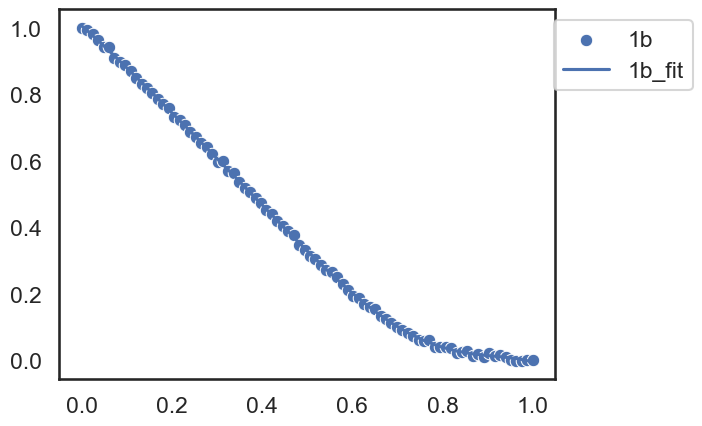

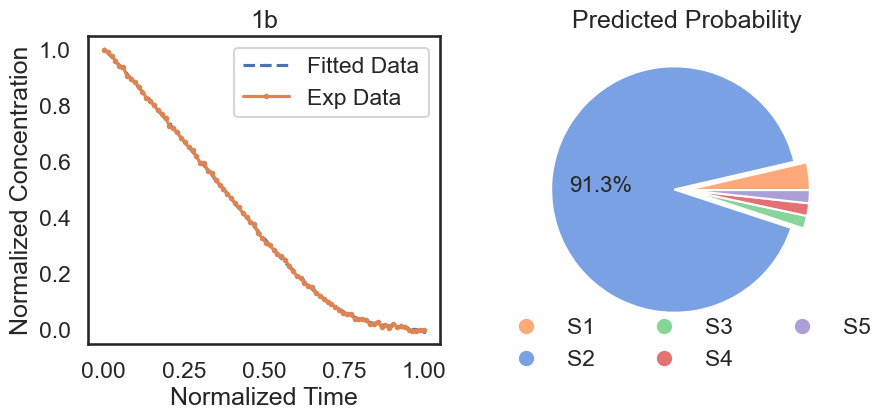

In [26]:
predict_on_csv(
    csv_path = './experimental_data/single_data.csv', 
    name = '1b', 
    class_num = 5, 
    fit = True, 
    fit_max_degree = 6,
)

### 4.2 with text copied from excel

### copy data from excel file with two columns: 'time' and 'S_conc' and predict with one single function with ease.
```python
exp_data = '''
5	75
60	72
120	68
240	59
360	54
480	53
1440	33
2880	21
4320	14
5760	11
'''
predict_on_text(
    exp_data_text=exp_data_text, 
    name= 'my_data', 
    class_num = 5, 
    fit = False,
)
```


In [33]:
def predict_on_text(
    exp_data_text: str, 
    name: str = 'my_exp_data', 
    class_num: int = 5, 
    fit: bool = True, 
    fit_max_degree: int = 6,
):
    '''
    Predict the reaction kinetic order of the experimental data, using text input. Different fit parameters would slightly affect the prediction results.

    Parameters
    ----------
    exp_data_text : str
        The text input of the experimental data, you can copy and paste the data from the excel file
    name : str, optional
        The name of the experimental data, by default 'my_exp_data'
    class_num : int, optional
        The number of classes, by default 5
    fit : bool, optional
        Fit the curve with polynomial regression, if data points are less than 20, suggest to set False, by default True
    fit_max_degree : int, optional
        The maximum degree of the polynomial regression, if data point is less than 30, suggest to use 4 or 5, by default 6

    Returns
    -------
    df_exp_pred_results : pd.DataFrame
        The prediction results of the experimental data
    '''


    sp_mode = 's'
    ag_model_root = './AutogluonModels/'
    feat = 'tsfresh_raw'
    ag_train_quality = 'best_quality'
    hours = 3.0

    time_raw = [float(i.split()[0]) for i in exp_data_text.split('\n') if i]
    s_conc_raw = [float(i.split()[1]) for i in exp_data_text.split('\n') if i]
    time = normalize(np.array(time_raw))
    s_conc = (np.array(s_conc_raw) - np.array(s_conc_raw)[-1]) / (np.array(s_conc_raw)[0] - np.array(s_conc_raw)[-1])
    time, s_conc = check_data(time, s_conc, name)
    time_point, s_conc_point = generate_time_conc_curve(time, s_conc, plot_fit_str=name, verbose=True, fit=fit, max_degree=fit_max_degree)
    df_exp_tsfresh_data = get_tsfresh_features(
        {
            name: {'s': s_conc_point},
        },
        sp_mode=sp_mode
    )

    df_exp_raw_data = conc_points2raw_data(
        {
            name: {'s': s_conc_point},
        },
        sp_mode=sp_mode
    )

    df_exp_merged_data = pd.merge(df_exp_raw_data, df_exp_tsfresh_data, on='id')
    class_list = [
        'S1',
        'S2',
        'S3',
        'S4',
        'S5',
    ]
    if class_num == 4:
        class_list.remove('S5')
    model_root = os.path.join(ag_model_root, f'{str(class_num)}_class', f'{feat}_feat__{sp_mode}__{ag_train_quality}__{hours}h')
    predictor = TabularPredictor.load(model_root)
    exp_proba = predictor.predict_proba(df_exp_merged_data)
    if class_num == 4:
        df_exp_pred_results = pd.DataFrame({
            'id': df_exp_merged_data['id'],
            'pred_1st': get_top_x_probs(exp_proba, x=1)['list_indices_1'],
            'pred_1st_proba': get_top_x_probs(exp_proba, x=1)['list_probs_1'],
            'pred_2nd': get_top_x_probs(exp_proba, x=2)['list_indices_2'],
            'pred_2nd_proba': get_top_x_probs(exp_proba, x=2)['list_probs_2'],
            'pred_3rd': get_top_x_probs(exp_proba, x=3)['list_indices_3'],
            'pred_3rd_proba': get_top_x_probs(exp_proba, x=3)['list_probs_3'],
            'pred_4th': get_top_x_probs(exp_proba, x=4)['list_indices_4'],
            'pred_4th_proba': get_top_x_probs(exp_proba, x=4)['list_probs_4'],
        })
    elif class_num == 5:
        df_exp_pred_results = pd.DataFrame({
            'id': df_exp_merged_data['id'],
            'pred_1st': get_top_x_probs(exp_proba, x=1)['list_indices_1'],
            'pred_1st_proba': get_top_x_probs(exp_proba, x=1)['list_probs_1'],
            'pred_2nd': get_top_x_probs(exp_proba, x=2)['list_indices_2'],
            'pred_2nd_proba': get_top_x_probs(exp_proba, x=2)['list_probs_2'],
            'pred_3rd': get_top_x_probs(exp_proba, x=3)['list_indices_3'],
            'pred_3rd_proba': get_top_x_probs(exp_proba, x=3)['list_probs_3'],
            'pred_4th': get_top_x_probs(exp_proba, x=4)['list_indices_4'],
            'pred_4th_proba': get_top_x_probs(exp_proba, x=4)['list_probs_4'],
            'pred_5th': get_top_x_probs(exp_proba, x=5)['list_indices_5'],
            'pred_5th_proba': get_top_x_probs(exp_proba, x=5)['list_probs_5'],
        })

    df_exp_pred_results = df_exp_pred_results.round(3)
    print('Prediction Results:')
    print(f'1st: {df_exp_pred_results.iloc[0]["pred_1st"]}, probability: {df_exp_pred_results.iloc[0]["pred_1st_proba"]:0.3f}')
    print(f'2nd: {df_exp_pred_results.iloc[0]["pred_2nd"]}, probability: {df_exp_pred_results.iloc[0]["pred_2nd_proba"]:0.3f}')
    print(f'3rd: {df_exp_pred_results.iloc[0]["pred_3rd"]}, probability: {df_exp_pred_results.iloc[0]["pred_3rd_proba"]:0.3f}')
    print(f'4th: {df_exp_pred_results.iloc[0]["pred_4th"]}, probability: {df_exp_pred_results.iloc[0]["pred_4th_proba"]:0.3f}')
    if class_num == 5:
        print(f'5th: {df_exp_pred_results.iloc[0]["pred_5th"]}, probability: {df_exp_pred_results.iloc[0]["pred_5th_proba"]:0.3f}')

    exp_proba = exp_proba[class_list]
    pie_data = {
        name: exp_proba.iloc[0].tolist(),
    }
    pie_colors = ['#FFA878', '#79A1E3', '#88D59A', '#E37275', '#AB9FD6']
    if class_num == 4:
        pie_colors.remove('#AB9FD6')

    def autopct_only_max(pct, sizes):
        '''
        only show the percentage of the largest value
        '''
        value = pct / 100.0
        tolerance = 1e-3
        if abs(value - max(sizes)) < tolerance:
            return f'{pct:.1f}%'
        else:
            return ''
        
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    if fit:
        axes[0].plot(
            time_point, s_conc_point,
            label='Fitted Data', 
            marker='.', markersize=3, linestyle='--'
        )
    else:
        axes[0].plot(
            time_point, s_conc_point,
            label='Interplolated Data', 
            marker='.', markersize=3, linestyle='--'
        )
    axes[0].plot(
        time, s_conc,
        label='Exp Data', 
        marker='o', markersize=3
    )
    # show legend
    axes[0].legend()
    axes[0].set_title(name)
    axes[0].set_xlabel('Normalized Time')
    axes[0].set_ylabel('Normalized Concentration')
    axes[0].set_ylim(-0.05, 1.05)

    explode = [0.1 if size == max(pie_data[name]) else 0 for size in pie_data[name]]

    axes[1].pie(
        pie_data[name],
        autopct=lambda pct: autopct_only_max(pct, pie_data[name]),
        startangle=0,
        colors=pie_colors,
        explode=explode,
        textprops={'fontsize': 16}
    )
    axes[1].set_title('Predicted Probability')
    class_display_list = ['S1', 'S2', 'S3', 'S4', 'S5']    
    if class_num == 4:
        class_display_list.remove('S5')
    axes[1].legend(
        handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors],
        labels=class_display_list,
        loc='lower center',           
        bbox_to_anchor=(0.5, -0.2), 
        ncol=3,
        frameon=False
    )
    return df_exp_pred_results

In [34]:
exp_data_text = '''
5	75
60	72
120	68
240	59
360	54
480	53
1440	33
2880	21
4320	14
5760	11
'''

my_data is fine
my_data is completed rxn


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


Prediction Results:
1st: S5, probability: 0.936
2nd: S3, probability: 0.019
3rd: S4, probability: 0.018
4th: S2, probability: 0.014
5th: S1, probability: 0.014


,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba,pred_5th,pred_5th_proba
0,my_data,S5,0.936,S3,0.019,S4,0.018,S2,0.014,S1,0.014


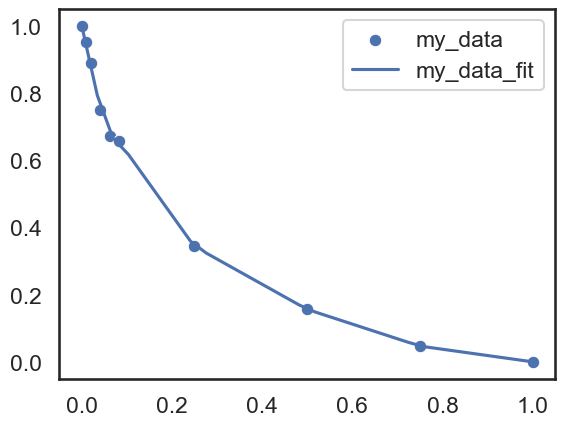

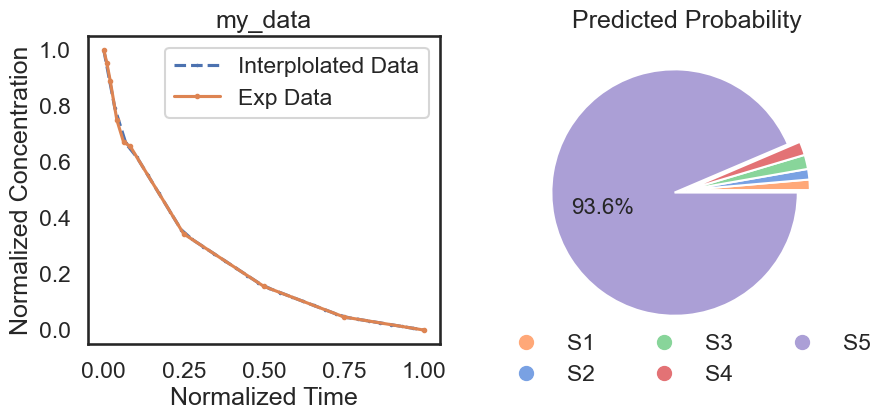

In [35]:
predict_on_text(
    exp_data_text=exp_data_text, 
    name= 'my_data', 
    class_num = 5, 
    fit = False,
)

my_data is fine
my_data is completed rxn
best degree: 4
best mse: 0.0006072521281137774


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]

Prediction Results:
1st: S5, probability: 0.939
2nd: S4, probability: 0.017
3rd: S3, probability: 0.017
4th: S2, probability: 0.014
5th: S1, probability: 0.014


,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba,pred_5th,pred_5th_proba
0,my_data,S5,0.939,S4,0.017,S3,0.017,S2,0.014,S1,0.014


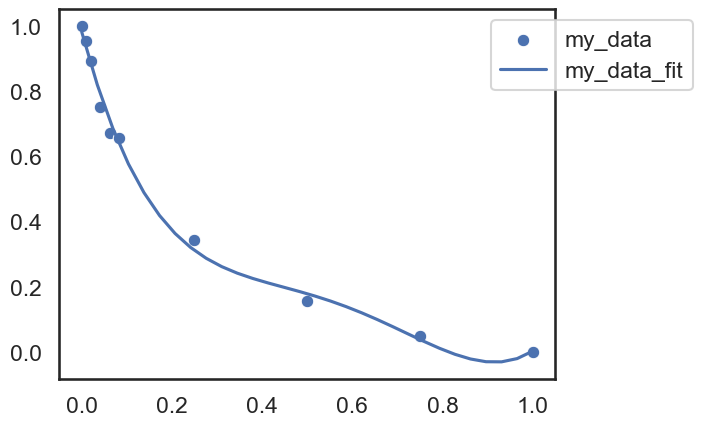

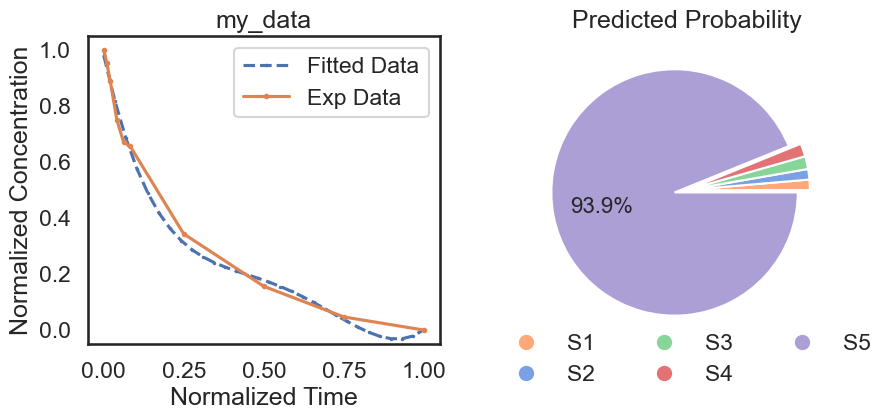

In [36]:
predict_on_text(
    exp_data_text=exp_data_text, 
    name= 'my_data', 
    class_num = 5, 
    fit = True,
    fit_max_degree = 4, 
)

my_data is fine
my_data is completed rxn
best degree: 4
best mse: 0.0006072521281137774


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s]


Prediction Results:
1st: S4, probability: 0.624
2nd: S3, probability: 0.364
3rd: S1, probability: 0.006
4th: S2, probability: 0.006


,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba
0,my_data,S4,0.624,S3,0.364,S1,0.006,S2,0.006


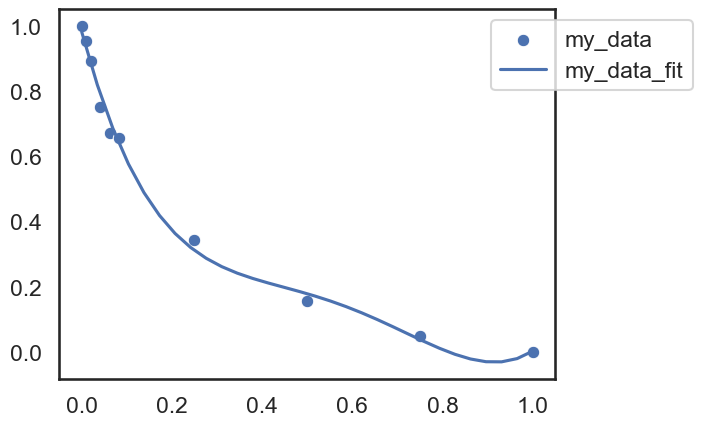

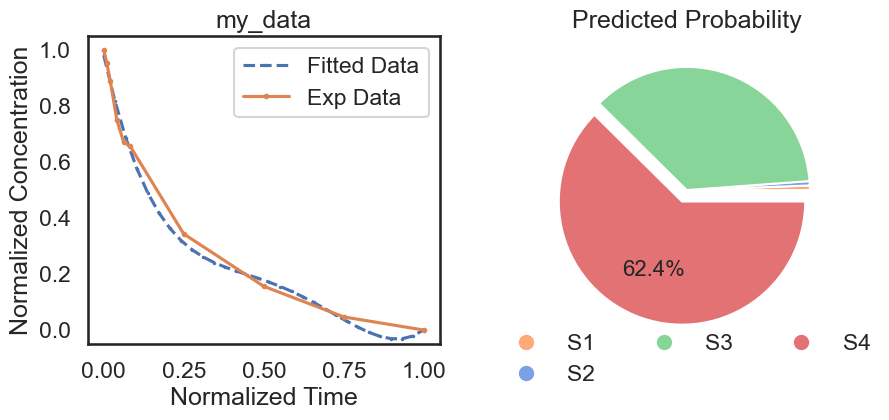

In [37]:
predict_on_text(
    exp_data_text=exp_data_text, 
    name= 'my_data', 
    class_num = 4, 
    fit = True,
    fit_max_degree = 4, 
)

my_data is fine
my_data is completed rxn


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 34.34it/s]


Prediction Results:
1st: S4, probability: 0.639
2nd: S3, probability: 0.351
3rd: S2, probability: 0.006
4th: S1, probability: 0.005


,id,pred_1st,pred_1st_proba,pred_2nd,pred_2nd_proba,pred_3rd,pred_3rd_proba,pred_4th,pred_4th_proba
0,my_data,S4,0.639,S3,0.351,S2,0.006,S1,0.005


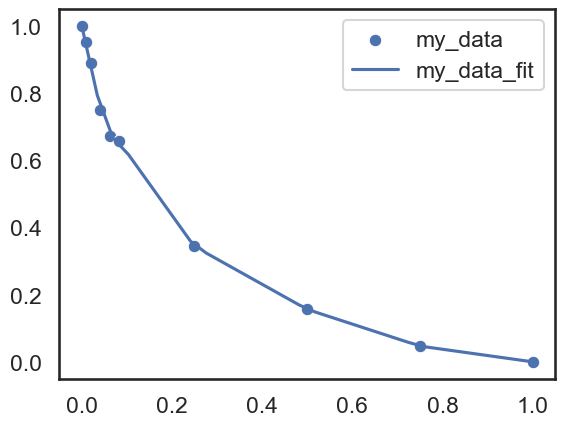

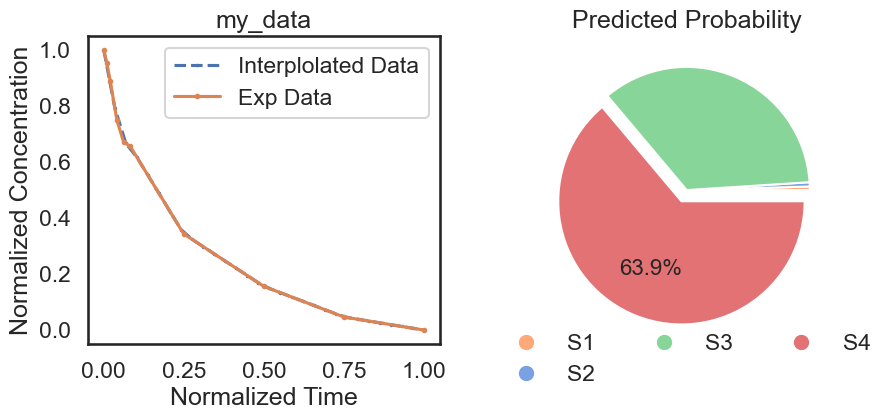

In [38]:
predict_on_text(
    exp_data_text=exp_data_text, 
    name= 'my_data', 
    class_num = 4, 
    fit = False,
)